# Condensed Spec Notebook

In [25]:
!git config --global user.name "LanceM28" 
!git config --global git config --global user.email "lmoreau@terpmail.umd.edu"

usage: git config [<options>]

Config file location
    --global              use global config file
    --system              use system config file
    --local               use repository config file
    --worktree            use per-worktree config file
    -f, --file <file>     use given config file
    --blob <blob-id>      read config from given blob object

Action
    --get                 get value: name [value-pattern]
    --get-all             get all values: key [value-pattern]
    --get-regexp          get values for regexp: name-regex [value-pattern]
    --get-urlmatch        get value specific for the URL: section[.var] URL
    --replace-all         replace all matching variables: name value [value-pattern]
    --add                 add a new variable: name value
    --unset               remove a variable: name [value-pattern]
    --unset-all           remove all matches: name [value-pattern]
    --rename-section      rename section: old-name new-name
    --remove-secti

In [26]:
#initialization

import numpy as np
import matplotlib.pyplot as plt
import yt
import os
from yt.funcs import mylog
mylog.setLevel(40) #has to do something with what errors get stored?

cell_fields = [
    "Density",
    "x-velocity",
    "y-velocity",
    "z-velocity",
    "Pressure",
    "Metallicity",
    # "dark_matter_density",
    "xHI",
    "xHII",
    "xHeII",
    "xHeIII",
]
'''Defining the field names given in the simulaiton to be loaded
Is this dynamic? is this more like a call or more like a label
'''
epf = [
    ("particle_family", "b"),
    ("particle_tag", "b"),
    ("particle_birth_epoch", "d"),
    ("particle_metallicity", "d"),
]
'''
Set up additional value slots for particles, 
allowing us to then hold the spectroscopic values we want in particles.
'''

'\nSet up additional value slots for particles, \nallowing us to then hold the spectroscopic values we want in particles.\n'

In [27]:
from BradenNebularLines import emission

In [ ]:
'''
cell_fields = [
    "Density",
    "x-velocity",
    "y-velocity",
    "z-velocity",
    "Pressure",
    "Metallicity",
    # "dark_matter_density",
    "xHI",
    "xHII",
    "xHeII",
    "xHeIII",
]
epf = [
    ("particle_family", "b"),
    ("particle_tag", "b"),
    ("particle_birth_epoch", "d"),
    ("particle_metallicity", "d"),
]
'''

# Cloudy Grid Run Bounds (log values)
# Umin, Umax, Ustep: -6.0 1.0 0.5
# Nmin, Nmax, Nstep: -1.0 6.0 0.5 
# Tmin, Tmax, Tstop: 3.0 6.0 0.1

lines=["H1_6562.80A","O1_1304.86A","O1_6300.30A","O2_3728.80A","O2_3726.10A","O3_1660.81A",
       "O3_1666.15A","O3_4363.21A","O3_4958.91A","O3_5006.84A", "He2_1640.41A","C2_1335.66A",
       "C3_1906.68A","C3_1908.73A","C4_1549.00A","Mg2_2795.53A","Mg2_2802.71A","Ne3_3868.76A",
       "Ne3_3967.47A","N5_1238.82A","N5_1242.80A","N4_1486.50A","N3_1749.67A","S2_6716.44A","S2_6730.82A"]

# Ionization Parameter Field
# Based on photon densities bins 1-4
# Should not include bin 1 -> Lyman Werner non-ionizing
# TODO check ionization parameter
def _ion_param(field, data): 
    from yt.frontends.ramses.field_handlers import RTFieldFileHandler
    p = RTFieldFileHandler.get_rt_parameters(ds).copy()
    p.update(ds.parameters)

    cgs_c = 2.99792458e10     #light velocity
    pd_2 = data['ramses-rt','Photon_density_2']*p["unit_pf"]/cgs_c #physical photon number density in cm-3
    pd_3 = data['ramses-rt','Photon_density_3']*p["unit_pf"]/cgs_c
    pd_4 = data['ramses-rt','Photon_density_4']*p["unit_pf"]/cgs_c

    photon = pd_2 + pd_3 + pd_4

    return photon/data['gas', 'number_density']  

# Temporarily testing rt fields
def _ion_param2(field, data): 
    from yt.frontends.ramses.field_handlers import RTFieldFileHandler
    p = RTFieldFileHandler.get_rt_parameters(ds).copy() # grabbing simulation parameters, is this grabbing constants?
    p.update(ds.parameters)

    cgs_c =  2.99792458e10     #light velocity
    pd_2 = data['rt','photon_density_2']#*p["unit_pf"]/cgs_c #physical photon number density in cm-3
    pd_3 = data['rt','photon_density_3']#*p["unit_pf"]/cgs_c
    pd_4 = data['rt','photon_density_4']#*p["unit_pf"]/cgs_c

    photon = pd_2 + pd_3 + pd_4

    return photon/data['gas', 'number_density']*data['gas', 'number_density']/data['gas', 'number_density']

yt.add_field(
    ('gas', 'ion-param'), 
    function=_ion_param, 
    sampling_type="cell", 
    units="cm**3", #this is how units are defined for added fields
    force_override=True
)

yt.add_field(
    ('gas', 'ion-param2'), 
    function=_ion_param2, 
    sampling_type="cell", 
    units="1", 
    force_override=True
)

# True divides emissions by density squared in interpolator
### Why set to true???
dens_normalized = True
if dens_normalized: 
    units = '1/cm**6'
else:
    units = '1'

# Add intensity fields for all lines in the list
for i in range(len(lines)):
    yt.add_field(
        #('gas', 'intensity_' + lines[i] + '_[erg_cm^{-2}_s^{-1}]'),
        ('gas', 'intensity_' + lines[i]),
        function=emission.get_line_emission(i, dens_normalized),
        sampling_type='cell',
        units=units,
        force_override=True
    )

yt.add_field(
        ('gas', 'intensity_halpha_norm'),
        function=emission.get_line_emission(0, True),
        sampling_type='cell',
        units='1/cm**6',
        force_override=True
)

yt.add_field(
        ('gas', 'intensity_oiii_norm'),
        function=emission.get_line_emission(9, True),
        sampling_type='cell',
        units='1/cm**6',
        force_override=True
)

f1 = "/Users/lamoreau/python/Aether Spectroscopy/output_00273"

ds = yt.load(f1)
ad = ds.all_data()

# For projections in a spherical region
sp = ds.sphere([0.49118094, 0.49275361, 0.49473726], (2000, "pc"))
sp2 = ds.sphere([0.49118094, 0.49275361, 0.49473726], (4000, "pc"))
ds.fields

In [29]:
sp = ds.sphere([0.49118094, 0.49275361, 0.49473726], (700, "pc"))

In [30]:
lines=["H1_6562.80A","O1_1304.86A","O1_6300.30A","O2_3728.80A","O2_3726.10A","O3_1660.81A",
       "O3_1666.15A","O3_4363.21A","O3_4958.91A","O3_5006.84A", "He2_1640.41A","C2_1335.66A",
       "C3_1906.68A","C3_1908.73A","C4_1549.00A","Mg2_2795.53A","Mg2_2802.71A","Ne3_3868.76A",
       "Ne3_3967.47A","N5_1238.82A","N5_1242.80A","N4_1486.50A","N3_1749.67A","S2_6716.44A","S2_6730.82A"] #
line_sums = []  # Start with an empty Python list
print(ds.field_info["gas", "intensity_H1_6562.80A"].get_source())
for line in enumerate(lines):
    wave_unmod = line[1].split("_")[-1]
    wavelength = wave_unmod[:-1]
    intensitys = sp.quantities.total_quantity(("gas", f"intensity_{line[1]}"))
    line_sums.append((float(intensitys), float(wavelength), f"intensity_{line[1]}"))  # Append the tuple
#sp.quantities. ###find the temperature of the gas
#avg_temp = sp.quantities.weighted_average_quantity(["gas", "Temperature"])
line_sums_array = np.array(line_sums)  # Convert to a NumPy array if needed
print(line_sums_array)
#print(sp.quantities.total_quantity(("gas","intensity_O1_1304.86A")))

    def _line_emission(field, data):
        interpolator=get_interpolator(idx, dens_normalized)

        # Change to log values
        U_val = data['gas', 'ion-param'].value
        N_val = data['gas', 'number_density'].value
        T_val = data['gas', 'temperature'].value

        # Cut off negative temperatures
        T_val = np.where(T_val < 0.0, 10e-4, T_val)

        U = np.log10(U_val)
        N = np.log10(N_val)
        T = np.log10(T_val)

        # Adjust log values to within bounds supported by
        # interpolation table
        Uadj = np.where(U < minU, minU, U)
        Uadj = np.where(Uadj > maxU, maxU, Uadj)

        Nadj = np.where(N < minN, minN, N)
        Nadj = np.where(Nadj > maxN, maxN, Nadj)

        Tadj = np.where(T < minT, minT, T)
        Tadj = np.where(Tadj > maxT, maxT, Tadj)
    
        tup = np.stack((Uadj, Nadj, Tadj), axis=-1)

        size  = Nadj.size
        # Testing with constant U, T -> density variation
        #tup = np.stack(([0.0]*size,

Text(0.5, 1.0, 'Intensity v. Wavelength for different lines')

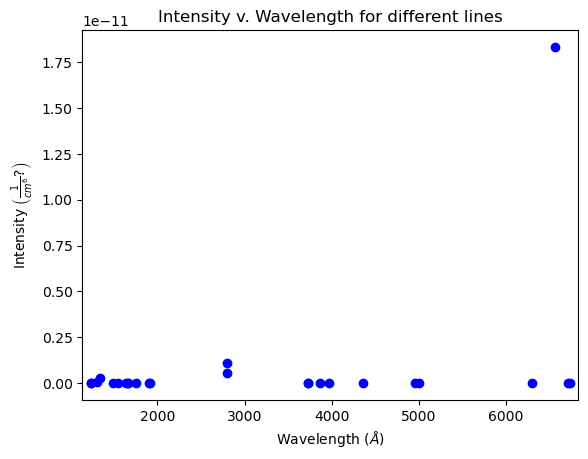

In [31]:
x_vals = line_sums_array[:,1].astype(float)
y_vals = line_sums_array[:,0].astype(float)
plt.plot(x_vals, y_vals, marker = "o", color = "blue",linestyle = " ")
plt.yscale("linear")
#plt.ylim([min(line_sums[:,0]), max(line_sums[:,0])])
plt.xlim([min(x_vals)-100, max(x_vals)+100])
plt.xlabel(r"Wavelength $(\AA)$")
plt.ylabel(r"Intensity $\left(\frac{1}{cm^6}?\right)$")
plt.title("Intensity v. Wavelength for different lines")

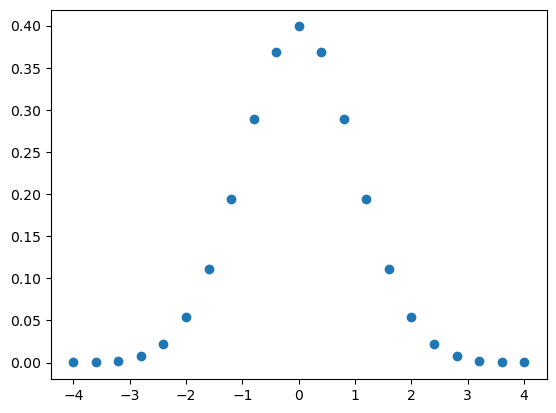

In [32]:
import scipy
fig, ax = plt.subplots(1)
x = np.linspace(-4,4,21)
mean = 0
sigma = 1
y = scipy.stats.norm.pdf(x, mean, sigma) 
ax.scatter(x,y)
#σ = (√(kT/m)) / c ### this will be the formula I use for determining sigma for each line

6562.8
1304.86
6300.3
3728.8
3726.1
1660.81
1666.15
4363.21
4958.91
5006.84
1640.41
1335.66
1906.68
1908.73
1549.0
2795.53
2802.71
3868.76
3967.47
1238.82
1242.8
1486.5
1749.67
6716.44
6730.82


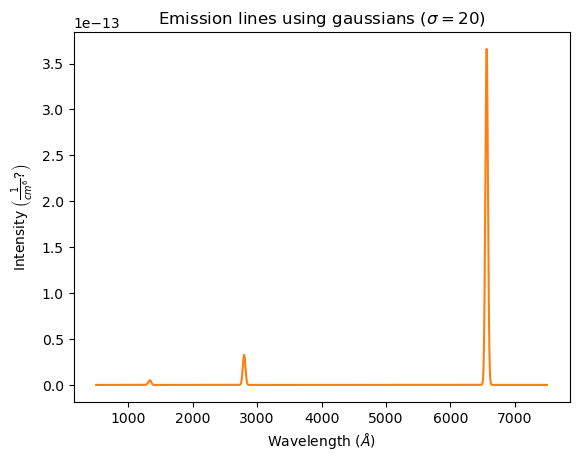

' gaussian_array = []\n#problem with i as an array?\nfor i in enumerate(np.zeros(len(x_vals))):\n    print(i)\n    gaussian_array[i] = gaussian(wavelength, y_vals[i], x_vals[i], sigma)\ngaussian_array = np.array(gaussian_array)\n#gaussian for each emission\n#add gaussian functions\n#apply over linspace of wavelength '

In [33]:
def gaussian(x, area, mean, std): #this should already exist look these things up!!!!
    return area * (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * std**2))
sigma = 20 #arbitrary value for now
wavelength = (min(x_vals)-100, max(x_vals)+100, 3000)
#how do we determine sigma
#how do we set this up so we can add gaussians together
y_tot = np.zeros(70000) #array for storing y values
x = np.linspace(500,7500, 70000) #wavelength range
for i in range(len(x_vals)):
    y = gaussian(x, y_vals[i], x_vals[i], sigma) # applies the gaussian for one peak over x array to obtain y values
    center_val = gaussian(x_vals[i], y_vals[i], x_vals[i], sigma)
    print(x_vals[i])
    #print(center_val/y_vals[i[0]])
    y_tot = y_tot+y 
    #print(int(np.round(x_vals[i[0]])))
    #print(x_vals[i[0]], y_tot[int(np.round(x_vals[i[0]]))-500]) #prints wavelength and gaussian peak at that point
#gaus_vals = gaussian
plt.plot(x,y_tot, marker = " ", color = "tab:orange", linestyle = "-")
plt.yscale("linear")
#plt.ylim(0,10**-31)
#plt.xlim(1050,1150)
plt.xlabel(r"Wavelength $(\AA)$")
plt.ylabel(r"Intensity $\left(\frac{1}{cm^6}?\right)$")
plt.title(r"Emission lines using gaussians ($\sigma = 20$)")
#plt.savefig("Gaussian_emission_plot")
plt.show()



""" gaussian_array = []
#problem with i as an array?
for i in enumerate(np.zeros(len(x_vals))):
    print(i)
    gaussian_array[i] = gaussian(wavelength, y_vals[i], x_vals[i], sigma)
gaussian_array = np.array(gaussian_array)
#gaussian for each emission
#add gaussian functions
#apply over linspace of wavelength """

12.171087046255657


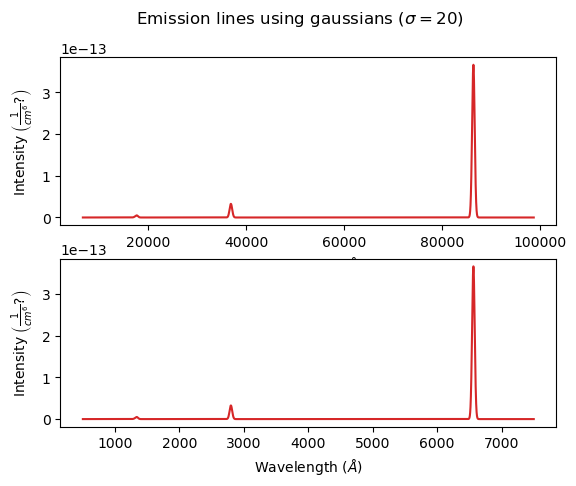

In [34]:
print(ds.current_redshift)
x_rshift = x * (ds.current_redshift+1)
fig, axs = plt.subplots(2,1)
axs[0].plot(x_rshift,y_tot, marker = " ", color = "tab:red", linestyle = "-")
axs[1].plot(x,y_tot, marker = " ", color = "tab:red", linestyle = "-")

axs[0].set_yscale("linear")
axs[1].set_yscale("linear")

#plt.ylim(0,10**-31)
#plt.xlim(1050,1150)
for ax in axs.flat:
    ax.set(xlabel = r"Wavelength $(\AA)$", ylabel = r"Intensity $\left(\frac{1}{cm^6}?\right)$")
fig.suptitle(r"Emission lines using gaussians ($\sigma = 20$)")
#plt.savefig("Gaussian_emission_plot")
### Don't know how this works
plt.show()
print(axs.flat)

No more log scale intensity! We need to care about signal to noise when we are looking at our spectra

The next process:

We want to add a bunch of temperature corrected gaussians together, normalize them back to one, maybe weight them by something

 1. Previous Graduate student made images with SKIRT software and some lines like Halpha, this is DUST stuff, tried to make things look like the ORION nebula
 * SKIRT can model the diffusion process, if we can do star by star this starts to matter 
 * Monte Carlo: lots of different trials, use that data to determine probabilistically what you will observe.

 2. Spectral Resolution of JWST (it is quite low so we have to choose what we want to model carefully) 
 * How JWST makes it's spectra (bin sizes kind of things)
 * Figure out how bins change with redshift

In [ ]:
plot1 = yt.PhasePlot(
    sp, ('gas', 'ion-param2'), ("gas", "temperature"), [("gas", "intensity_H1_6562.80A")], weight_field=None
)

plot2 = yt.PhasePlot(
    sp, ("gas", "number_density"), ("gas", "ion-param2"), [("gas", "intensity_H1_6562.80A")], weight_field=None
)

plot3 = yt.PhasePlot(
    sp, ("gas", "temperature"), ("gas", "number_density"), [("gas", "intensity_H1_6562.80A")], weight_field=None
)



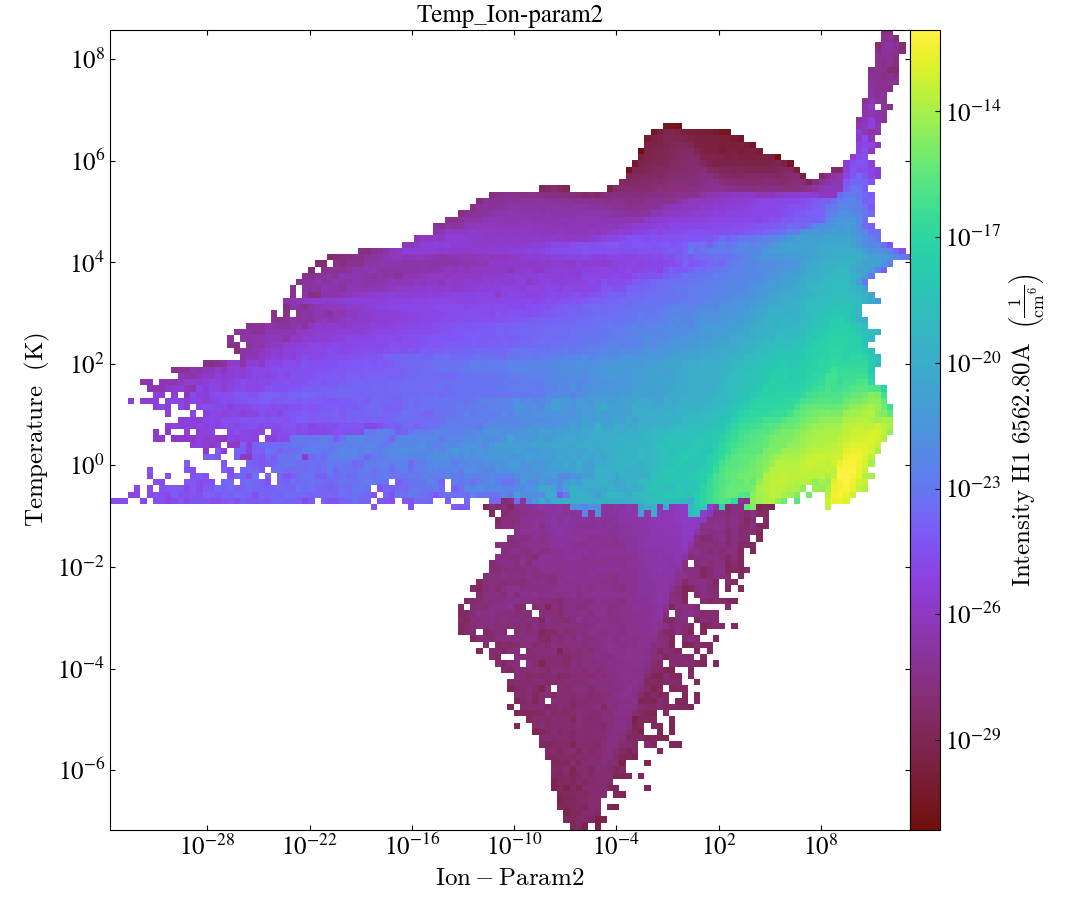


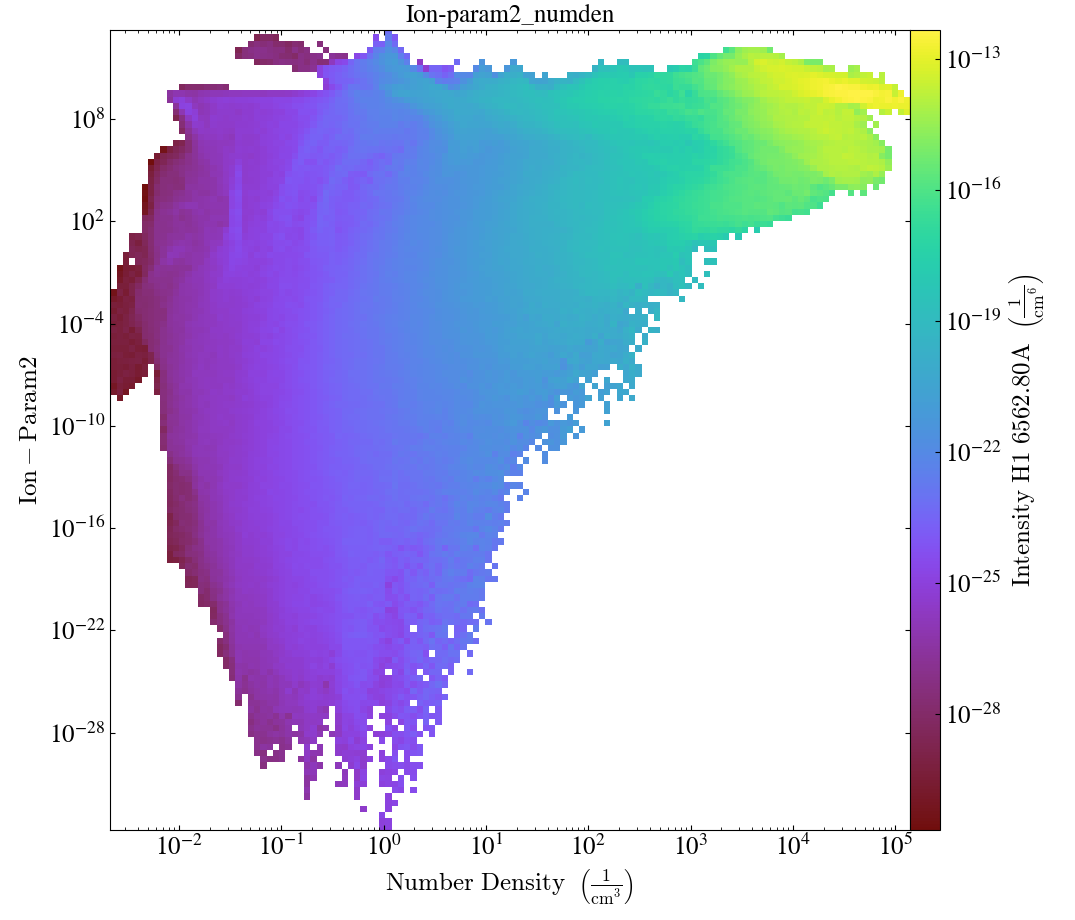


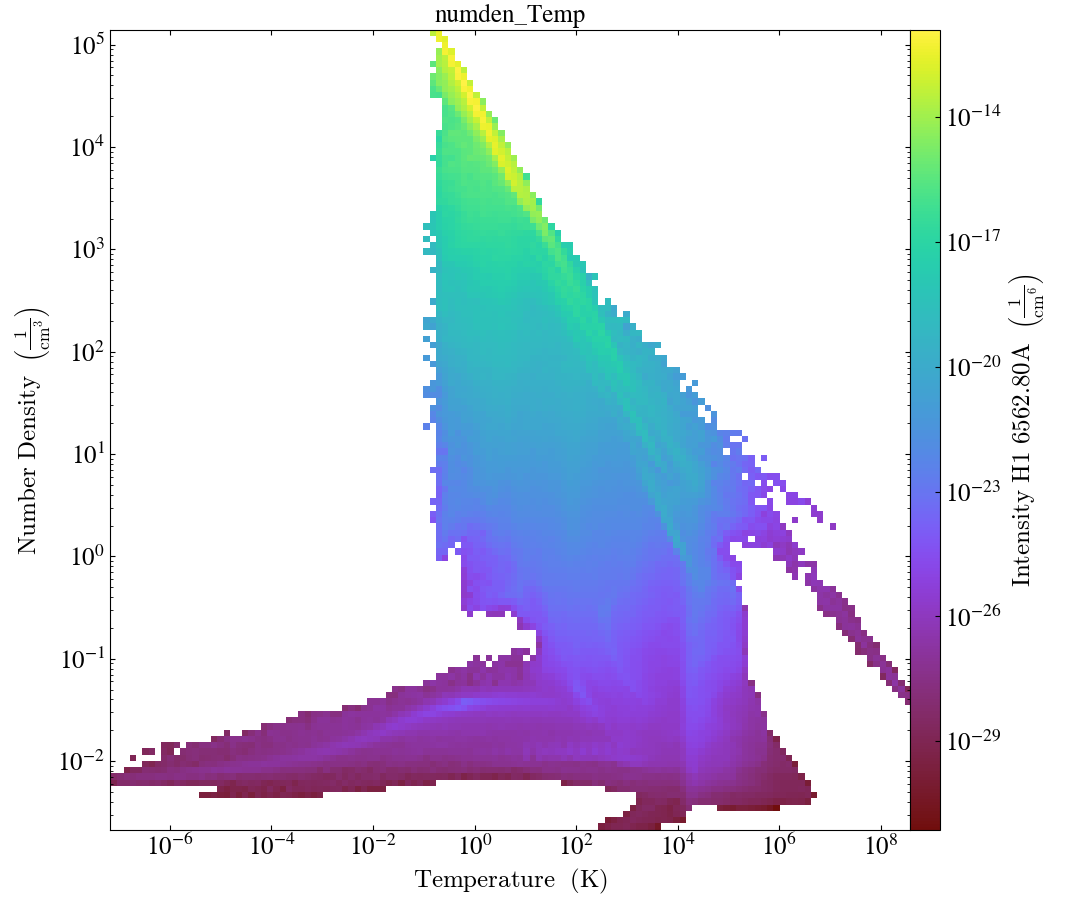

In [ ]:
titles = ["Temp_Ion-param2", "Ion-param2_numden", "numden_Temp"]
plots = [plot1, plot2, plot3]
for i in range(len(titles)):
    plots[i].annotate_title(titles[i])
    plots[i].show()
    #plots[i].save(titles[i])

In [ ]:
plot1.save("")

In [37]:
intvint = yt.PhasePlot(
    sp, ("gas", "intensity_H1_6562.80A"), ("gas", "intensity_O3_4363.21A"), [("gas", "temperature")], weight_field=None
)


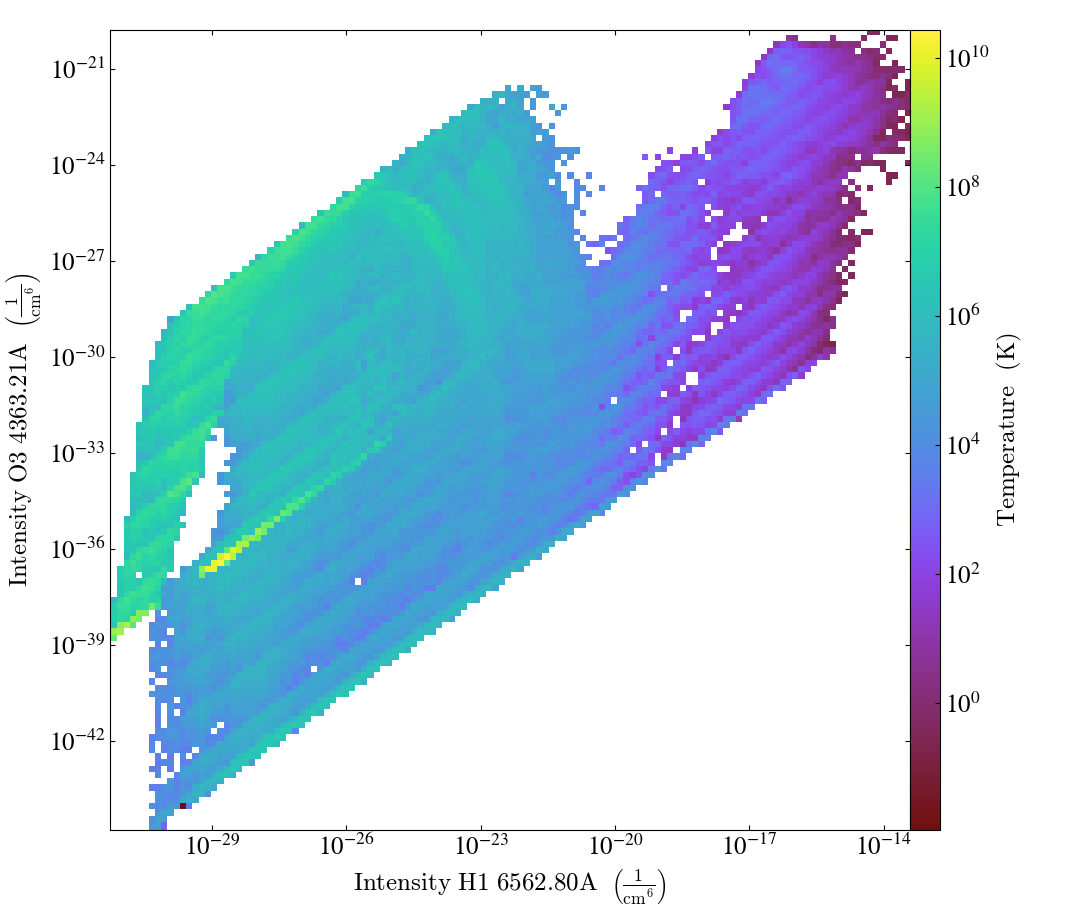

In [38]:
intvint.show()

In [39]:
intvint2 = yt.PhasePlot(
    sp, ("gas", "intensity_H1_6562.80A"), ("gas", "intensity_O2_3726.10A"), [("gas", "temperature")], weight_field=None
)


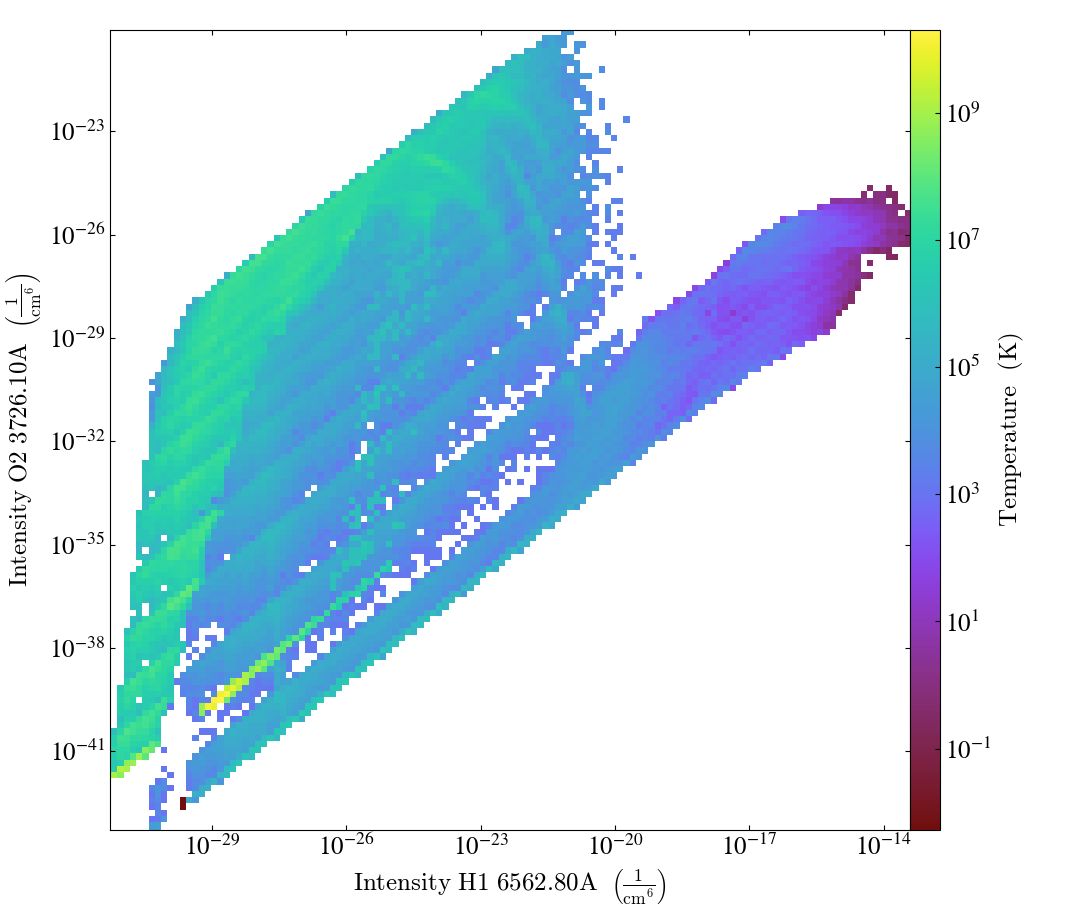

In [40]:
intvint2.show()